# **Feature subset selection with the Genetic Algorithm**

In this notebook we will look at **Genetic Algorithm (GA)**.

Task 1: Tournament Selection Implementation
In this task, tournament selection is implemented in the GA() function to allow selection based on fitness comparison among a subset (tournament) of individuals. With a tournament size of 3, the algorithm randomly selects three individuals from the population and chooses the one with the highest fitness. This selection process adds diversity to the population and maintains roulette wheel selection as an alternative, which can be selected with a function argument.

Do our imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

Mount Google Drive so that we can load our dataset.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the data.

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/auto-lpkm.tsv', sep='\t', header=0)

The last column is the $y$, i.e., liters per 100 km which we must learn to predict.

In [4]:
X = data.to_numpy()[:, 0:-1]
y = data.to_numpy()[:, -1]
data = data.drop('l100km', axis=1)
feature_names = data.columns.values

First we will run the code without the next code cell execution.

Then we will come back here and execute this code to make more features and repeat executing all the next cells.

In [5]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X = poly_features.fit_transform(X)

Create Linear Regression model with all features and evaluate it using Cross-Validation.

In [6]:
model = LinearRegression()

yHat = cross_val_predict(model, X, y, cv=10)

MSE = mean_squared_error(y, yHat)
R2 = r2_score(y, yHat)

print('Result with all features:')
print('MSE: %.3f' % MSE)
print('R^2: %.3f' % R2)

Result with all features:
MSE: 3.880
R^2: 0.735


Task 2: Uniform Crossover Implementation
Uniform crossover is added to the GA() function, providing an alternative to single-point crossover. In uniform crossover, genes from two parents are swapped based on a 50/50 probability, enhancing genetic diversity. This crossover method is selectable by passing an argument to the function, allowing easy switching between single-point and uniform crossover. Uniform crossover offers finer control over gene mixing, potentially improving convergence.

## **Feature selection with GA**
And now this notebook's most important part – let's implement GA and do feature selection with it.

Task 3: Configuration Testing and Evaluation
Task 3 sets up four configurations combining selection (roulette or tournament) and crossover (single-point or uniform) methods. Each configuration is run multiple times to compute the average
𝑅
2
R
2
  value, providing a reliable measure of each configuration's performance. The results are compared using fitness vs. generation plots for each configuration, helping to identify the most effective combination for the dataset.

In [7]:

def GA(X, y, model, feature_names, selection_method='roulette', crossover_method='single_point'):
  m = X.shape[1]

  # configuration
  pop_size = 10 # even number
  num_generations = 30
  crossover_prob = 0.9
  mutation_prob = 1 / m

  # matrices to store the current and the next generation
  pop = np.random.choice(a=[False, True], size=(pop_size, m))
  pop_next = np.empty((pop_size, m), dtype=bool)

  # overall best found solution
  overall_best_chromosome = np.full(m, False)  # the overall best found solution
  overall_best_fitness = np.Inf  # fitness of the best found solution

  # for storing statistics
  stats = np.empty((num_generations, 2))

  # GA iterations
  for generation in range(0, num_generations):

    # evaluation of each individual
    fitness = np.empty(pop_size)
    for i in range(0, pop_size):
      chromosome = pop[i, :]
      if not np.any(chromosome):
        fitness[i] = np.Inf
        continue
      X_selected = X[:, chromosome]
      yHat = cross_val_predict(model, X_selected, y, cv=10)
      fitness[i] = mean_squared_error(y, yHat)

    # find the best individual of the generation
    best_individual = np.argmin(fitness)
    best_fitness = fitness[best_individual]
    best_chromosome = pop[best_individual, :]
    # save best fitness of the generation to stats
    stats[generation] = [np.ma.masked_invalid(fitness).mean(), best_fitness]
    # if better than the overall best, remember it
    if best_fitness < overall_best_fitness:
      overall_best_fitness = best_fitness
      overall_best_chromosome = best_chromosome.copy()

    # print best result in the current generation
    print(f'Generation {generation}: Best fitness = {fitness[best_individual]}')
    if feature_names.shape[0] == m:
      print(''.join(['1' if bit else '0' for bit in pop[best_individual, :]]) + ': ' + '\t'.join(feature_names[pop[best_individual, :]]))
    else:
      print(''.join(['1' if bit else '0' for bit in pop[best_individual, :]]))

    # no need to run the rest of the code for the last generation
    if generation >= num_generations - 1:
      break

    # some preparations for roulette wheel selection
    inverted_fitness = 1 / fitness
    roulette_probs = np.zeros(pop_size)
    roulette_probs[0] = inverted_fitness[0] / np.sum(inverted_fitness)
    for i in range(1, pop_size):
      roulette_probs[i] = roulette_probs[i - 1] + inverted_fitness[i] / np.sum(inverted_fitness)

    # Tournament selection function
    def tournament_selection():
        tournament_contestants = np.random.choice(pop_size, tournament_size, replace=False)
        contestant_fitness = fitness[tournament_contestants]
        winner_index = tournament_contestants[np.argmin(contestant_fitness)]
        return winner_index

    # loop through population size with step 2 to create the next population
    for i in range(0, pop_size, 2):
      # Select parents based on chosen selection method
      if selection_method == 'tournament':
        parent1 = tournament_selection()
        parent2 = tournament_selection()
      else:  # default to roulette wheel selection
        parent1 = np.argmax(roulette_probs >= np.random.rand())
        parent2 = np.argmax(roulette_probs >= np.random.rand())

      # Perform crossover based on chosen crossover method
      if crossover_method == 'uniform':
        if crossover_prob > np.random.rand():
          mask = np.random.rand(m) < 0.5
          pop_next[i, :] = np.where(mask, pop[parent1, :], pop[parent2, :])
          pop_next[i + 1, :] = np.where(mask, pop[parent2, :], pop[parent1, :])
        else:
          pop_next[i, :] = pop[parent1, :]
          pop_next[i + 1, :] = pop[parent2, :]
      else:  # default to single-point crossover
        if crossover_prob > np.random.rand():
          crossover_pos = np.random.randint(1, high=m)
          pop_next[i, :] = np.hstack([pop[parent1, 0:crossover_pos], pop[parent2, crossover_pos:]])
          pop_next[i + 1, :] = np.hstack([pop[parent2, 0:crossover_pos], pop[parent1, crossover_pos:]])
        else:
          pop_next[i, :] = pop[parent1, :]
          pop_next[i + 1, :] = pop[parent2, :]

    # Mutation
    mutate = np.random.rand(pop_size, m) <= mutation_prob
    np.logical_not(pop_next, where=mutate, out=pop_next)

    # Update population
    pop = pop_next.copy()

  # Print the overall best result
  print()
  print('Overall best fitness =', overall_best_fitness)
  if feature_names.shape[0] == m:
    print(''.join(['1' if bit else '0' for bit in overall_best_chromosome]) + ': ' + '\t'.join(feature_names[overall_best_chromosome]))
  else:
    print(''.join(['1' if bit else '0' for bit in overall_best_chromosome]))

  # Compute coefficient of determination
  X_selected = X[:, overall_best_chromosome]
  yHat = cross_val_predict(model, X_selected, y, cv=10)
  overall_best_R2 = r2_score(y, yHat)
  print('Overall best R2 =', overall_best_R2)

  return stats, overall_best_R2


Run the function.

In [8]:
stats, R2 = GA(X, y, model, feature_names)

Generation 0: Best fitness = 2.4962356277498867
10011110100100000001111011110101101001001100101100111001111000000110100000110001100111110010111110010000101000011110011
Generation 1: Best fitness = 2.483590364474992
10011110101100000001111011110101101001001100101100111001111000000110100000110001100111110010111110010000101000011110011
Generation 2: Best fitness = 2.537910451152115
10001010001010111101111101100000110010110000101010000101010000011101000000011101100011110111000111101000101101001001111
Generation 3: Best fitness = 2.4707806353804496
00101010000010010101010001011000100110011011001000110100110010101101000000011101100010110111000111101000101101001001111
Generation 4: Best fitness = 2.588517962776401
10010010000010010101010001011000110110011001001000111001111000000110100000110001100111110010100111101000101101001001111
Generation 5: Best fitness = 2.3569582178412434
0001110000011100010000101110110100100111100100100011000011001010101110011111000110001111011100011110100010111100100

Plot statistics of the algorithm run.

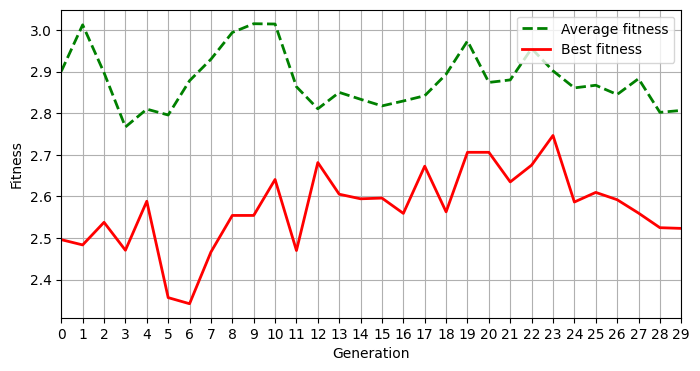

In [9]:
plt.figure(figsize=(8, 4))
generations = range(0, stats.shape[0])
plt.plot(generations, stats[:, 0], "g--", label="Average fitness", linewidth=2)
plt.plot(generations, stats[:, 1], "r-", label="Best fitness", linewidth=2)
plt.grid()
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.xticks(generations)
plt.legend(loc="upper right")
plt.xlim([0, stats.shape[0] - 1])
plt.show()

---
*Notebook by Gints Jēkabsons*